In [1]:
# pip install ipympl
# pip install mpl_point_clicker

# Common Libraries

In [1]:
import os
import cv2
import numpy as np
import nibabel as nb
import pandas as pd
import matplotlib.pylab as plt
from nilearn.image import resample_to_img, math_img
from sklearn.cluster import KMeans
from mpl_point_clicker import clicker
from glob import glob
import json
from nilearn.plotting import view_img

# Custom Libraries

In [2]:
import sys
sys.path.append("/home/seojin")
import surfAnalysisPy as surf # Dierdrichsen lab's library

sys.path.append("/home/seojin/Seojin_commonTool/Module")
from surface_analysis import vol_to_surf, surface_cross_section
from sj_brain_mask import multi_label_roi_manager

# Params

In [5]:
reference_img = "/mnt/ext1/seojin/HR/exp_blueprint_0324v4/fMRI_data/output/roi/mask/group_mask.nii.gz"
surf_hemisphere = "L" # L: Left, R: right
surf_resolution = 32

surf_dir_path = f"/mnt/sda2/Common_dir/Atlas/Surface/fs_LR_{surf_resolution}"
pial_surf_path = os.path.join(surf_dir_path, f"fs_LR.{surf_resolution}k.{surf_hemisphere}.pial.surf.gii")
white_surf_path = os.path.join(surf_dir_path, f"fs_LR.{surf_resolution}k.{surf_hemisphere}.white.surf.gii")
template_surface_path = os.path.join(surf_dir_path, f"fs_LR.{surf_resolution}k.{surf_hemisphere}.flat.surf.gii")

temp_dir = "/mnt/ext1/seojin/temp/rois/Brodmann"
os.makedirs(temp_dir, exist_ok = True)

# Functions

In [6]:
# 유클리드 거리 계산 함수
def euclidean_distance(p1, p2):
    return np.linalg.norm(np.array(p1) - np.array(p2))

# Region Growing 알고리즘
def region_growing(data, seed_index, threshold=1.0):
    visited = set()  # 방문한 좌표
    queue = [seed_index]  # 탐색 큐
    region = []  # 결과 영역

    while queue:
        current_index = queue.pop(0)
        if current_index in visited:
            continue

        # 현재 좌표를 결과에 추가하고 방문 처리
        visited.add(current_index)
        region.append(data[current_index])

        # 현재 좌표
        current_point = data[current_index]

        # 모든 다른 점들과 거리 계산
        for idx, point in enumerate(data):
            if idx not in visited and euclidean_distance(current_point, point) <= threshold:
                queue.append(idx)

    return np.array(region)

# Brodmann ROI

In [31]:
# Path to the file
/home/seojin/Brodmann/

brodmann_nifti_path = "/usr/local/afni/abin/Brodmann_pijn_afni.nii.gz"
brodmann_info_path = "/usr/local/afni/abin/Brodmann_pijn_afni_info.csv"

In [32]:
brodmann_info = pd.read_csv(brodmann_info_path)

In [33]:
label_info = {}
for i, row in brodmann_info.iterrows():
    label_info[row["label"]] = row["description"]

In [34]:
roi_manager = multi_label_roi_manager(labeled_img = brodmann_nifti_path, 
                                      label_info = label_info, 
                                      reference_img = nb.load(reference_img))

/home/seojin/anaconda3/envs/surfVis/lib/python3.10/site-packages/nilearn/image/resampling.py:805: FutureWarning: From release 0.13.0 onwards, this function will, by default, copy the header of the input image to the output. Currently, the header is reset to the default Nifti1Header. To suppress this warning and use the new behavior, set `copy_header=True`.
  return resample_img(


In [59]:
roi_names = np.array(list(roi_manager.label_info.values()))

is_target_hemi_roi_names = [("ctx-lh" if surf_hemisphere == "L" else "ctx-rh") in roi_name for roi_name in roi_names]
target_roi_names = roi_names[is_target_hemi_roi_names]

In [93]:
target_roi_names

array(['ctx-lh-BA1_3', 'ctx-lh-BA2', 'ctx-lh-BA4', 'ctx-lh-BA5',
       'ctx-lh-BA6', 'ctx-lh-BA7', 'ctx-lh-BA8', 'ctx-lh-BA9',
       'ctx-lh-BA10', 'ctx-lh-BA11', 'ctx-lh-BA13', 'ctx-lh-BA16',
       'ctx-lh-BA17', 'ctx-lh-BA18', 'ctx-lh-BA19', 'ctx-lh-BA20',
       'ctx-lh-BA21', 'ctx-lh-BA22', 'ctx-lh-BA23', 'ctx-lh-BA24',
       'ctx-lh-BA25', 'ctx-lh-BA26_29_30', 'ctx-lh-BA27', 'ctx-lh-BA28',
       'ctx-lh-BA31', 'ctx-lh-BA32', 'ctx-lh-BA33', 'ctx-lh-BA34',
       'ctx-lh-BA35_36', 'ctx-lh-BA37', 'ctx-lh-BA38', 'ctx-lh-BA39',
       'ctx-lh-BA40', 'ctx-lh-BA41_42_52', 'ctx-lh-BA43', 'ctx-lh-BA44',
       'ctx-lh-BA45', 'ctx-lh-BA46', 'ctx-lh-BA47'], dtype='<U17')

# Make temporary rois

In [100]:
roi_file_paths = []
for roi_name in target_roi_names:
    temp_file_name = roi_name + ".nii.gz"
    temp_file_path = os.path.join(temp_dir, temp_file_name)
    
    roi_img = roi_manager.make_roi_with_search(keywords = [roi_name])
    nb.save(roi_img, temp_file_path)

    roi_file_paths.append(temp_file_path)

# Load surface data

In [75]:
temploate_surface_data = nb.load(template_surface_path)
vertex_data = temploate_surface_data.darrays[0].data

n_vertex, _ = vertex_data.shape

# Original surface

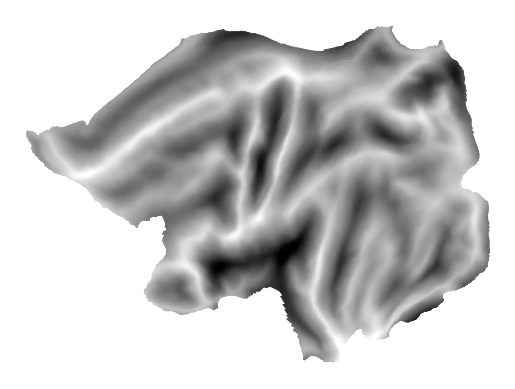

In [76]:
surf_ax = surf.plot.plotmap(data = np.zeros(n_vertex), 
                            surf = f"fs{surf_resolution}k_{surf_hemisphere}",
                            threshold = 0.01)

# Surface representation

In [77]:
cmap = "CMRmap"
alpha = 0.3

In [103]:
surf_roi_dummy = np.zeros(n_vertex)

roi_value = 1
for path in roi_file_paths[0:1]:
    surf_roi = vol_to_surf(path, pial_surf_path, white_surf_path, depths = [1.0, 0.8])
    surf_roi_data = np.where(surf_roi > 0.001, roi_value, 0)

    surf_roi_dummy = np.where(surf_roi_dummy == 0, surf_roi_data, surf_roi_dummy)
    roi_value += 1

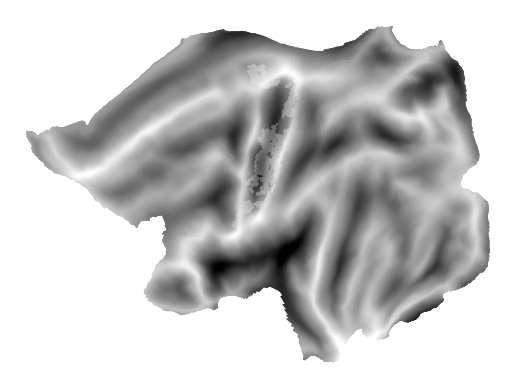

In [104]:
ax = surf.plot.plotmap(data = surf_roi_dummy, 
                       surf = f"fs{surf_resolution}k_{surf_hemisphere}",
                       threshold = 0.01,
                       alpha = alpha,
                       cmap = cmap)

# ROI - text

In [17]:
uq_roi_value = np.unique(surf_roi_dummy)
uq_roi_value = uq_roi_value[uq_roi_value != 0]

In [18]:
seed_idx = 0

mean_vertex_loc_info = {} 
for roi_name, roi_value in zip(roi_nick_names, uq_roi_value):
    vertex_locs = vertex_data[surf_roi_dummy == roi_value][:, :2] # xy coordinates
    if roi_name in ["OB", "ParaC", "PC"]:
        region = region_growing(vertex_locs, seed_idx, threshold = 10)
    else:
        region = vertex_locs
    
    mean_vertex_loc = list(np.mean(region, axis = 0))
    mean_vertex_loc_info[roi_name] = mean_vertex_loc


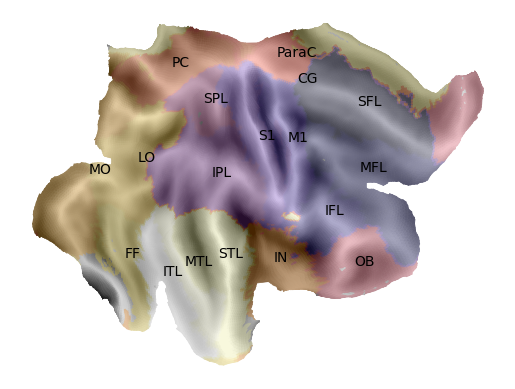

In [19]:
for i, roi_name in enumerate(mean_vertex_loc_info):
    loc = mean_vertex_loc_info[roi_name]
    ax.text(x = loc[0], y = loc[1], s = roi_name)
ax.get_figure()

# Sulcus drawing - Central sulcus

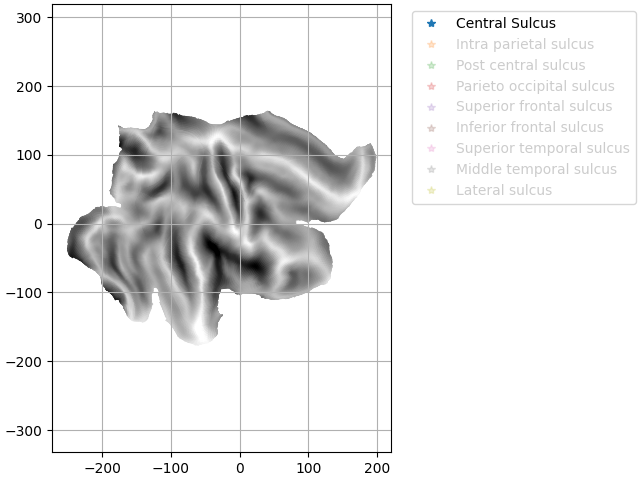

In [20]:
%matplotlib ipympl

if not os.path.exists(sulcus_path):
    fig, ax = plt.subplots(constrained_layout=True)
    marking_labels = ["Central Sulcus", 
                      "Intra parietal sulcus",
                      "Post central sulcus",
                      "Parieto occipital sulcus",
                      "Superior frontal sulcus",
                      "Inferior frontal sulcus",
                      "Superior temporal sulcus",
                      "Middle temporal sulcus",
                      "Lateral sulcus"]
    klicker = clicker(ax, marking_labels, markers = np.repeat("*", len(marking_labels)))

    ax_ = surf.plot.plotmap(data = np.zeros(n_vertex), 
                            surf = f"fs{surf_resolution}k_{surf_hemisphere}",
                            threshold = 0.01)
    ax_.grid(True)
    ax_.axis("on")
else:
    pass

In [22]:
# Save sulcus
if not os.path.exists(sulcus_path):
    marking_data_info = klicker.get_positions()
    for sulcus_name in marking_data_info:
        marking_data_info[sulcus_name] = np.array(marking_data_info[sulcus_name]).tolist()
    
    with open(sulcus_path, "w") as file:
        json.dump(marking_data_info, file)
else:
    with open(sulcus_path, "r") as file:
        marking_data_info = json.load(file)

# Show sulcus

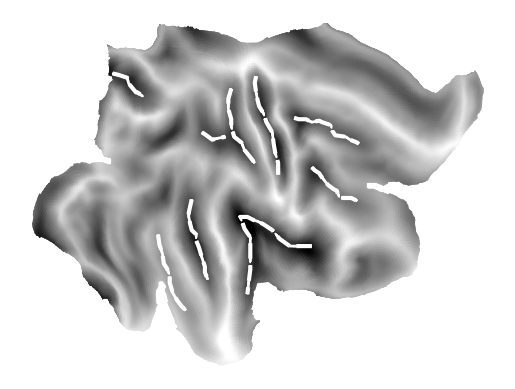

In [30]:
%matplotlib inline

for sulcus_name in marking_data_info:
    surf_ax.plot(np.array(marking_data_info[sulcus_name])[:, 0], 
                 np.array(marking_data_info[sulcus_name])[:, 1], 
                 color = "white",  
                 linestyle='dashed')
surf_ax.get_figure()